In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import copy
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import re

In [2]:
root = r".\data upload\0510" # enter data file path
file_name = r"main data.xlsx" # enter your file name
or_file_name = r"ologit results.xlsx"
df = pd.read_excel(os.path.join(root, file_name)) 

# Subjective career satisfaction

In [3]:
'''
"I am satisfied with the progress I have made \ntowards meeting my research achievement goals.",
"I am satisfied with the progress I have made \ntowards meeting my career achievement goals.",
"I have been recognized for \nmy contributions to scholarly communities.",
Please rate your overall satisfaction with your current or most recent marriage or partnership.
'''

def gen_res(df):
    satis = ["res_ach2","car_dev2","contrib2"]

    res = pd.DataFrame()
    for i in range(len(satis)):
        a = pd.crosstab([df["married_child"],df["gender_new"]],df[satis[i]]).drop(["Non-binary"], level="gender_new")
        total = a.sum(level=[0], axis=0)
        total.index = pd.MultiIndex.from_product([total.index, ["Total"]])
        a = pd.concat([a,total],axis=0).sort_index(level=0)
        a = a.div(a.apply(sum, axis=1),axis=0)*100
        a.columns = pd.MultiIndex.from_product([[i], a.columns])
        res = pd.concat([res,a],axis=1)

    res2 = pd.DataFrame()
    df1 = df[df["married_child"].isin([2,3])]
    for i in range(len(satis)):
        a = pd.crosstab(df1["gender_new"],df1[satis[i]]).drop(["Non-binary"])
        total = a.sum(axis=0)
        total.name = "Total"
        a = a.append(total)
        a = a.div(a.apply(sum, axis=1),axis=0)*100
        a.columns = pd.MultiIndex.from_product([[i], a.columns])
        res2 = pd.concat([res2,a],axis=1)

    res2.index = pd.MultiIndex.from_product([["All"], res2.index])
    res = pd.concat([res,res2])
    return res

df0 = df[df["area_Med"] == 1]
res=gen_res(df0)

In [4]:
# odds ratio

def plot_forest(axes,
                data,
                ypos=[0,1,2],
                xlim=[-1,1],
                ylim=[-0.8,2.3],
                groups = ["parent", "non-parent"],
                palette = ["black","black"],
                xlabel="Odds ratio (women/men)",
               vline=1,
               sharex = 0):
    for i in range(len(axes)):
        ax1 = axes[i]
        for j in range(len(groups)):
            cut = (data["group"]==j) & (data["question"]==i)
            ax1.plot(data.loc[cut, ["low","up"]].values[0],
                    [ypos[j]] * 2,
                    color = palette[j],
                    label = groups[j])
            # add marker
            ax1.plot(data.loc[cut, xlabel].values[0],
                       [j],
                     marker="o",
                     color = palette[j])
        ax1.set_xlim(*xlim)
        ax1.set_ylim(*ylim)
        ax1.set_xlabel(xlabel,loc="center",fontsize=8)

        ax1.tick_params(axis='both', labelsize=8)
        ax1.set_yticks(ypos)
        ax1.set_yticklabels([])
            
        ax1.grid(color="black",axis="x",alpha=0.04)
        ax1.axvline(x = vline, linestyle ='--', color="black",alpha=0.1)
        if i % 2==0:
            ax1.set_facecolor("whitesmoke")
        if i != len(questions) -1:
            ax1.set_xlabel(None)
            ax1.set_xticklabels([])

def sueststar(axes,
              xpos=[-0.3,0.3],
              ypos=[0,1,2],
              offset=-0.5,
              xlim=[-0.32,1],
              ylim=[-0.8,2.3]):
    for i in range(len(axes)):
        ax1 = axes[i]
        # add logit sig stars
        for j in range(len(groups)):
            cut = (df_odd["group"]==j) & (df_odd["question"]==i)
            pstar = df_odd.loc[cut, "P>z"].values[0]
            if not pd.isna(pstar):
                ax1.text(xpos[0], ypos[j]+offset, "{:.3f}".format(pstar),fontsize=8)
        if i == 0:
            ax1.text(xpos[0], ypos[-1], "p",fontsize=8, fontweight="bold")
        
        #add suest stars
        diffstar =  df_odd.loc[(df_odd["group"]==1) & (df_odd["question"]==i), "diff"].values[0]
        if not pd.isna(diffstar):
            ax1.text(xpos[1], 0.5+offset, "{:.3f}".format(diffstar),fontsize=8)
        if i == 0:
            ax1.text(xpos[1], ypos[-1], "p (SUEST)",fontsize=8, fontweight="bold")
        ax1.set_ylim(*ylim)
        ax1.set_xlim(*xlim)
        if i % 2==0:
            ax1.set_facecolor("whitesmoke")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
def plot_hbar(axes,
              data,
              target_ans = 1,
              ypos=[0,1,2],
              xlim=[0,99],
              ylim=[-0.8,2.3],
              w=0.3,
              groups = ["parent", "non-parent"],
              colors = ["#009FC3","#FEC64D"], # male, female
              xlabel="Percentage of satisfaction"):
    mc =  [2,3]
    mctext = groups[::-1]

    for q in range(len(axes)):
        ax2 = axes[q]
        for gender in ["Men","Women"]:
            temp = data.loc[pd.MultiIndex.from_product([[2,3],[gender]]),(q,target_ans)]
            if gender == "Men":
                ax2.barh([ypos[1]-0.5*w,ypos[0]-0.5*w], temp, align='center', height=w, label="Men",color=colors[0])
            if gender == "Women":
                ax2.barh([ypos[1]+0.5*w,ypos[0]+0.5*w], temp, align='center', height=w, label="Women",color=colors[1])

        ax2.set_xlabel(xlabel,loc="center",fontsize=8)
        ax2.tick_params(axis='both', labelsize=8)
        if q != len(questions) -1:
            ax2.set_xlabel(None)
        if q % 2==0:
            ax2.set_facecolor("whitesmoke")

        ax2.set_ylim(*ylim)
        ax2.set_xlim(*xlim)
        ax2.grid(color="black",axis="x",alpha=0.04)

        ax2.tick_params(axis='both', labelsize=8)
        ax2.set_yticks(ypos)
        ax2.set_yticklabels(groups+[questions[q]])
        ax2.get_yticklabels()[-1].set_weight("bold")
        if q != len(axes)-1:
            ax2.set_xlabel(None)
            ax2.set_xticklabels([])
    handles1 = [Line2D([0],[0], color="white", marker='o', markerfacecolor=c,linewidth=0, markersize=7) for c in colors]
    axes[0].legend(handles1, ["Men","Women"],bbox_to_anchor=(1,1.1),fontsize=7,handletextpad=0,borderpad=0)

# objective achievement

In [5]:
def plot_diff(axes,
              a_means,
              ypos=[0,1,2],
              xlim=[-0.32,1],
              ylim=[-0.8,2.3],
              w=0.3,
              groups = ["parent", "non-parent"],
              colors = ["#009FC3","#B30437"], # male, female
              xlabel="Mean diff. (women - men)"):
    for i in range(len(a_means)):
        a_mean = a_means[i]
        ax1 = axes[i]
        
        for m in [2,3]:
            data = a_mean.loc[a_mean["married_child"]==m,0]
            colormat=np.where(data>0,colors[1],colors[0])
            if m == 2:
                ax1.barh([ypos[1],ypos[1]], data, height=w, color=colormat)
            else:
                ax1.barh([ypos[0],ypos[0]], data, height=w, color=colormat)
                
        if i == len(a_means)-1:
            ax1.set_xlabel(xlabel, fontsize=8,ha="center",va="center")
        if i % 2==0:
            ax1.set_facecolor("whitesmoke")

        ax1.legend_ = None
        ax1.set_ylim(*ylim)
        ax1.set_xlim(*xlim)
        ax1.axvline(x=0,linestyle="--",color="black",alpha=0.1)
        ax1.grid(color="black",axis="x",alpha=0.04)
        
        ax1.tick_params(axis='both', labelsize=8)
        ax1.set_yticks(ypos)
        ax1.set_yticklabels(groups+[questions[i]])
        ax1.get_yticklabels()[-1].set_weight("bold")
        if i != len(axes)-1:
            ax1.set_xlabel(None)
            ax1.set_xticklabels([])
    handles1 = [Line2D([0],[0], color="white", marker='o', markerfacecolor=c,linewidth=0, markersize=7) for c in colors]
    axes[-1].legend(handles1, ["Negative","Positive"],loc="best",fontsize=7,handletextpad=0,borderpad=0)

#test
# fig, axes = plt.subplots(3,1, figsize=(3.5,1.6),dpi=300, sharex="col")
# plt.tight_layout()
# sns.despine(left=True, bottom=True, right=True)
# plt.subplots_adjust(hspace = 0, wspace = 0.05)
# plot_diff(axes,
#         a_means)
# plt.show()

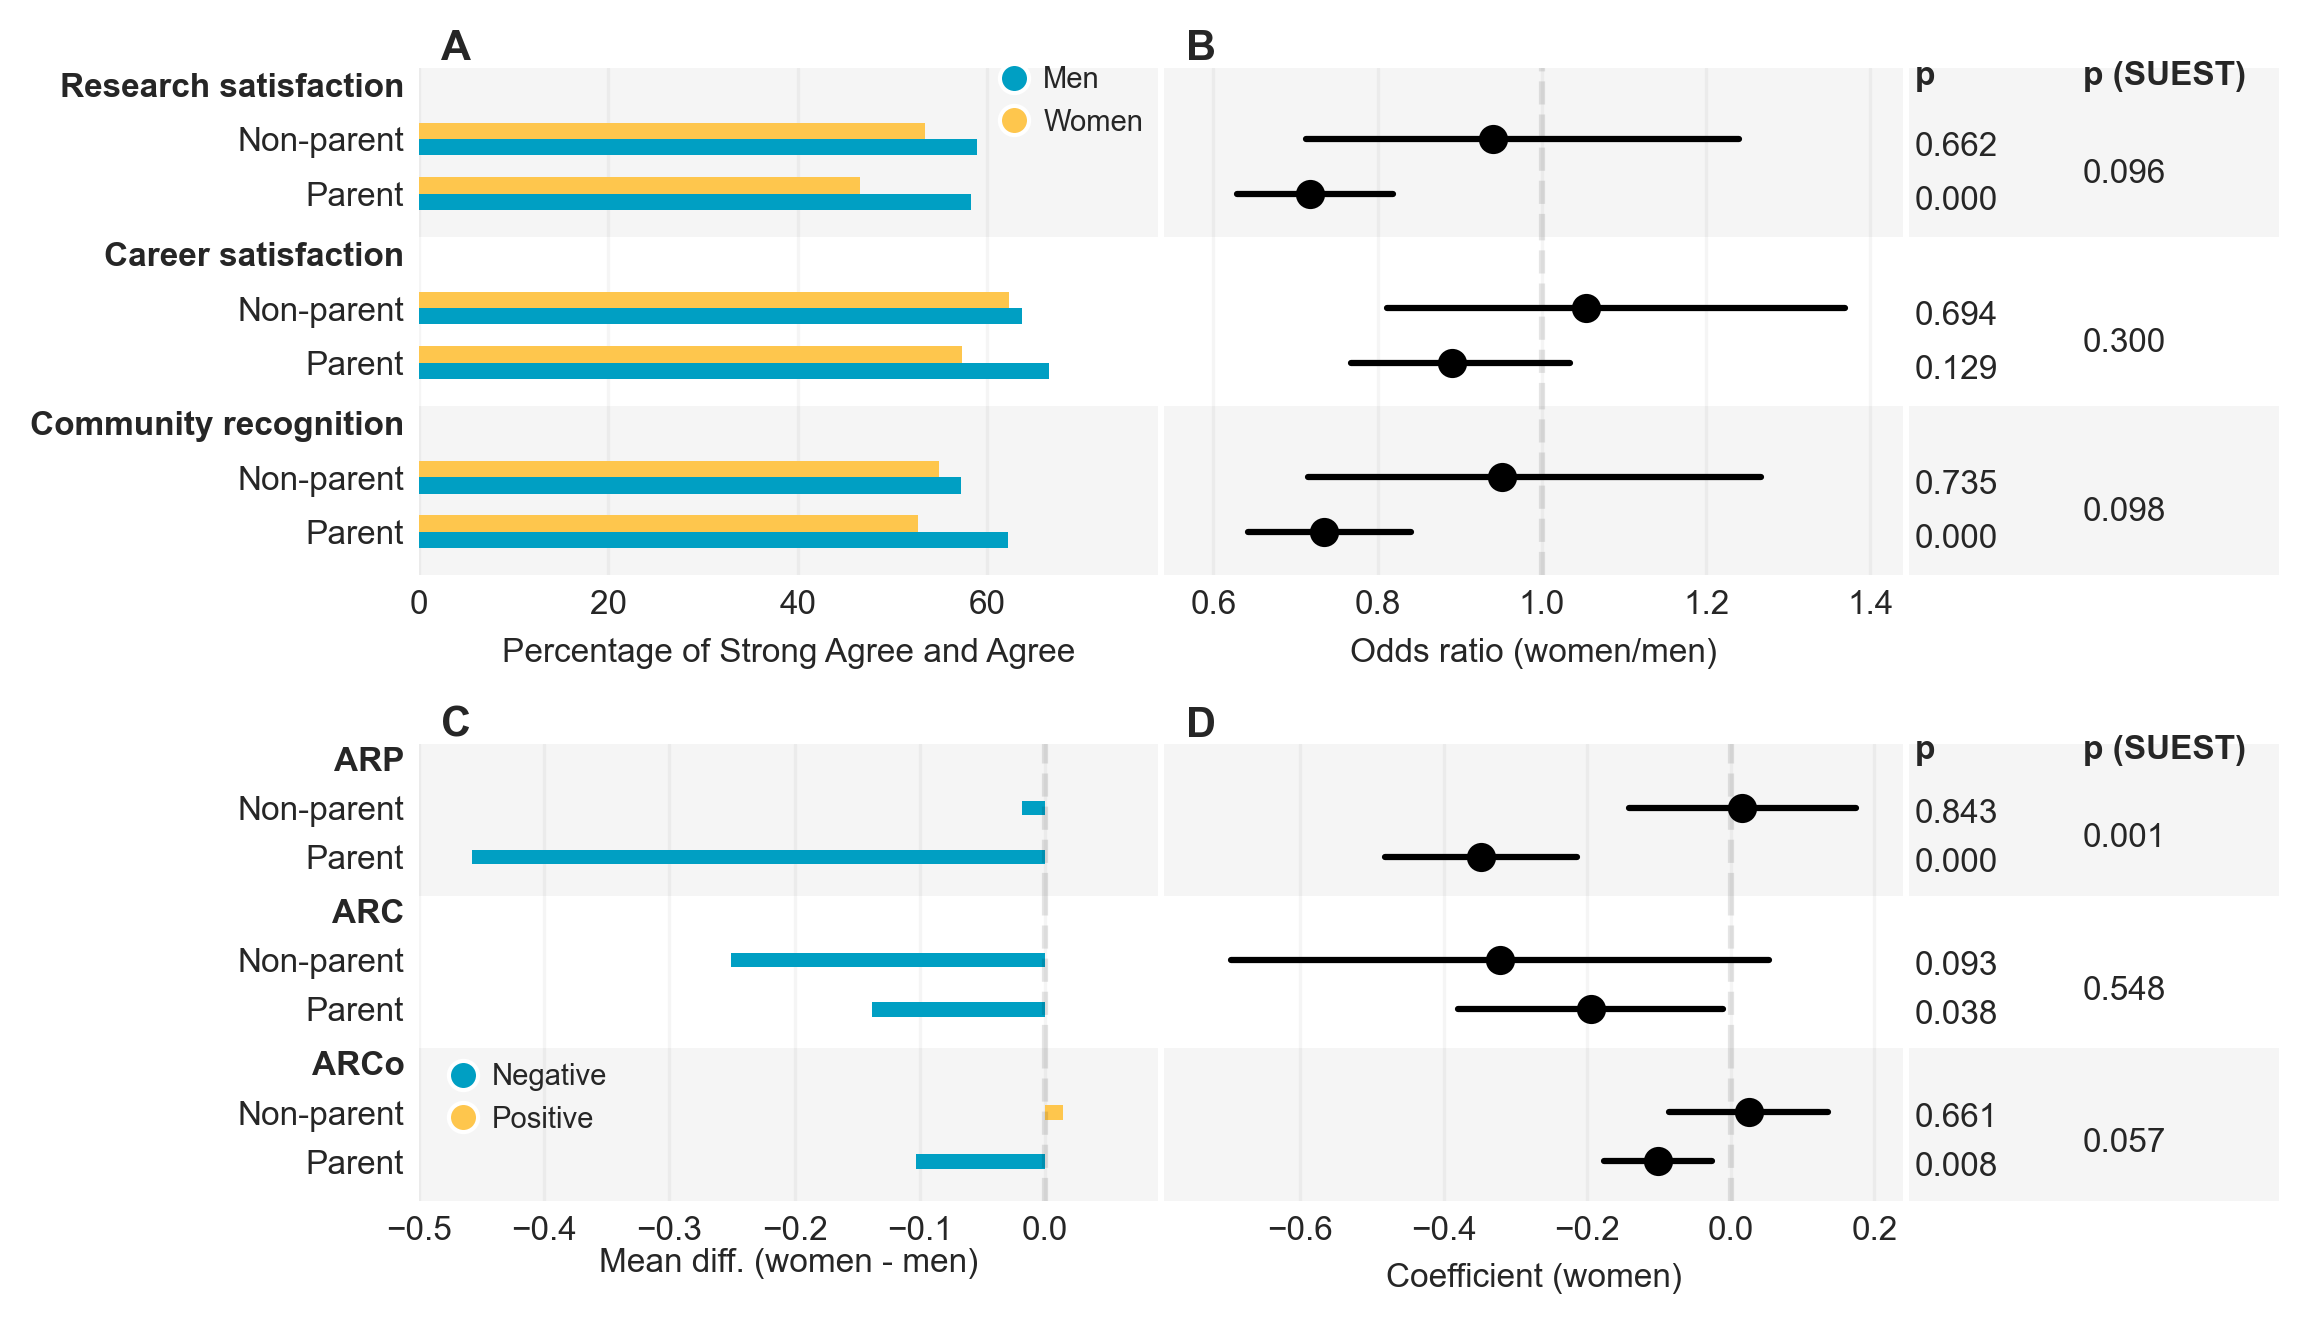

In [9]:
# across all areas

def gen_multi_gs(figsize=(8,8), nrow=3,down_nrow=3, wspace=0.01, hspace=0.35, width_ratios=[1,1,0.5],height_ratios=[1,0.9]):
    fig = plt.figure(constrained_layout=True, figsize=figsize,dpi=300)
    gs0 = GridSpec(2, 3, wspace=wspace, hspace=hspace, width_ratios=width_ratios, height_ratios=height_ratios)
    gs00 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,0],wspace=0,hspace=0)
    gs01 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,1],wspace=0,hspace=0)
    gs02 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,2],wspace=0,hspace=0)
    gs10 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,0],wspace=0,hspace=0)
    gs11 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,1],wspace=0,hspace=0)
    gs12 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,2],wspace=0,hspace=0)
    
    axes_set = []
    for gs in [gs00, gs01, gs02]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(nrow)])
    for gs in [gs10, gs11, gs12]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(down_nrow)])
    return fig, axes_set

fig, axes_set= gen_multi_gs(figsize=(8,5))
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="subjective")
df_odd = df_odd # change area
df0 = df # change area
res=gen_res(df0)

questions = ["Research satisfaction",
"Career satisfaction",
"Community recognition"]
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          ypos=ypos,
          xlim=[0,78],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of Strong Agree and Agree")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[0.54,1.44],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# bottom
df2 = df0[df0["gender_new"]!="Non-binary"]
plt.style.use("seaborn-white")
a_means = []
questions = ["ARP","ARC", "ARCo"]
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="biblio")

for val in ["rel_npap","rel_cite","uni_cola"]:
    pre = df2[df2["married_child"].isin([2,3]) & ~df2["rel_npap"].isnull()]
    pre0 = pd.pivot_table(pre,
                        values = val,
                        index = "gender_new",
                        columns = "married_child",
                        aggfunc=[np.mean, np.median])
    pre = pd.concat([pre0], keys=['All'], names=['rank'])
    a = pre.diff().drop("Men", level="gender_new").droplevel(level="gender_new")
    a_mean = a["mean"].stack().reset_index()
    a_means.append(a_mean)

plot_diff(axes_set[3],
          a_means,
          ypos=ypos,
          xlim=[-0.5,0.09],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors,
          xlabel="Mean diff. (women - men)")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[-0.79,0.24],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Coefficient (women)",
           vline=0)

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'fig1.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)

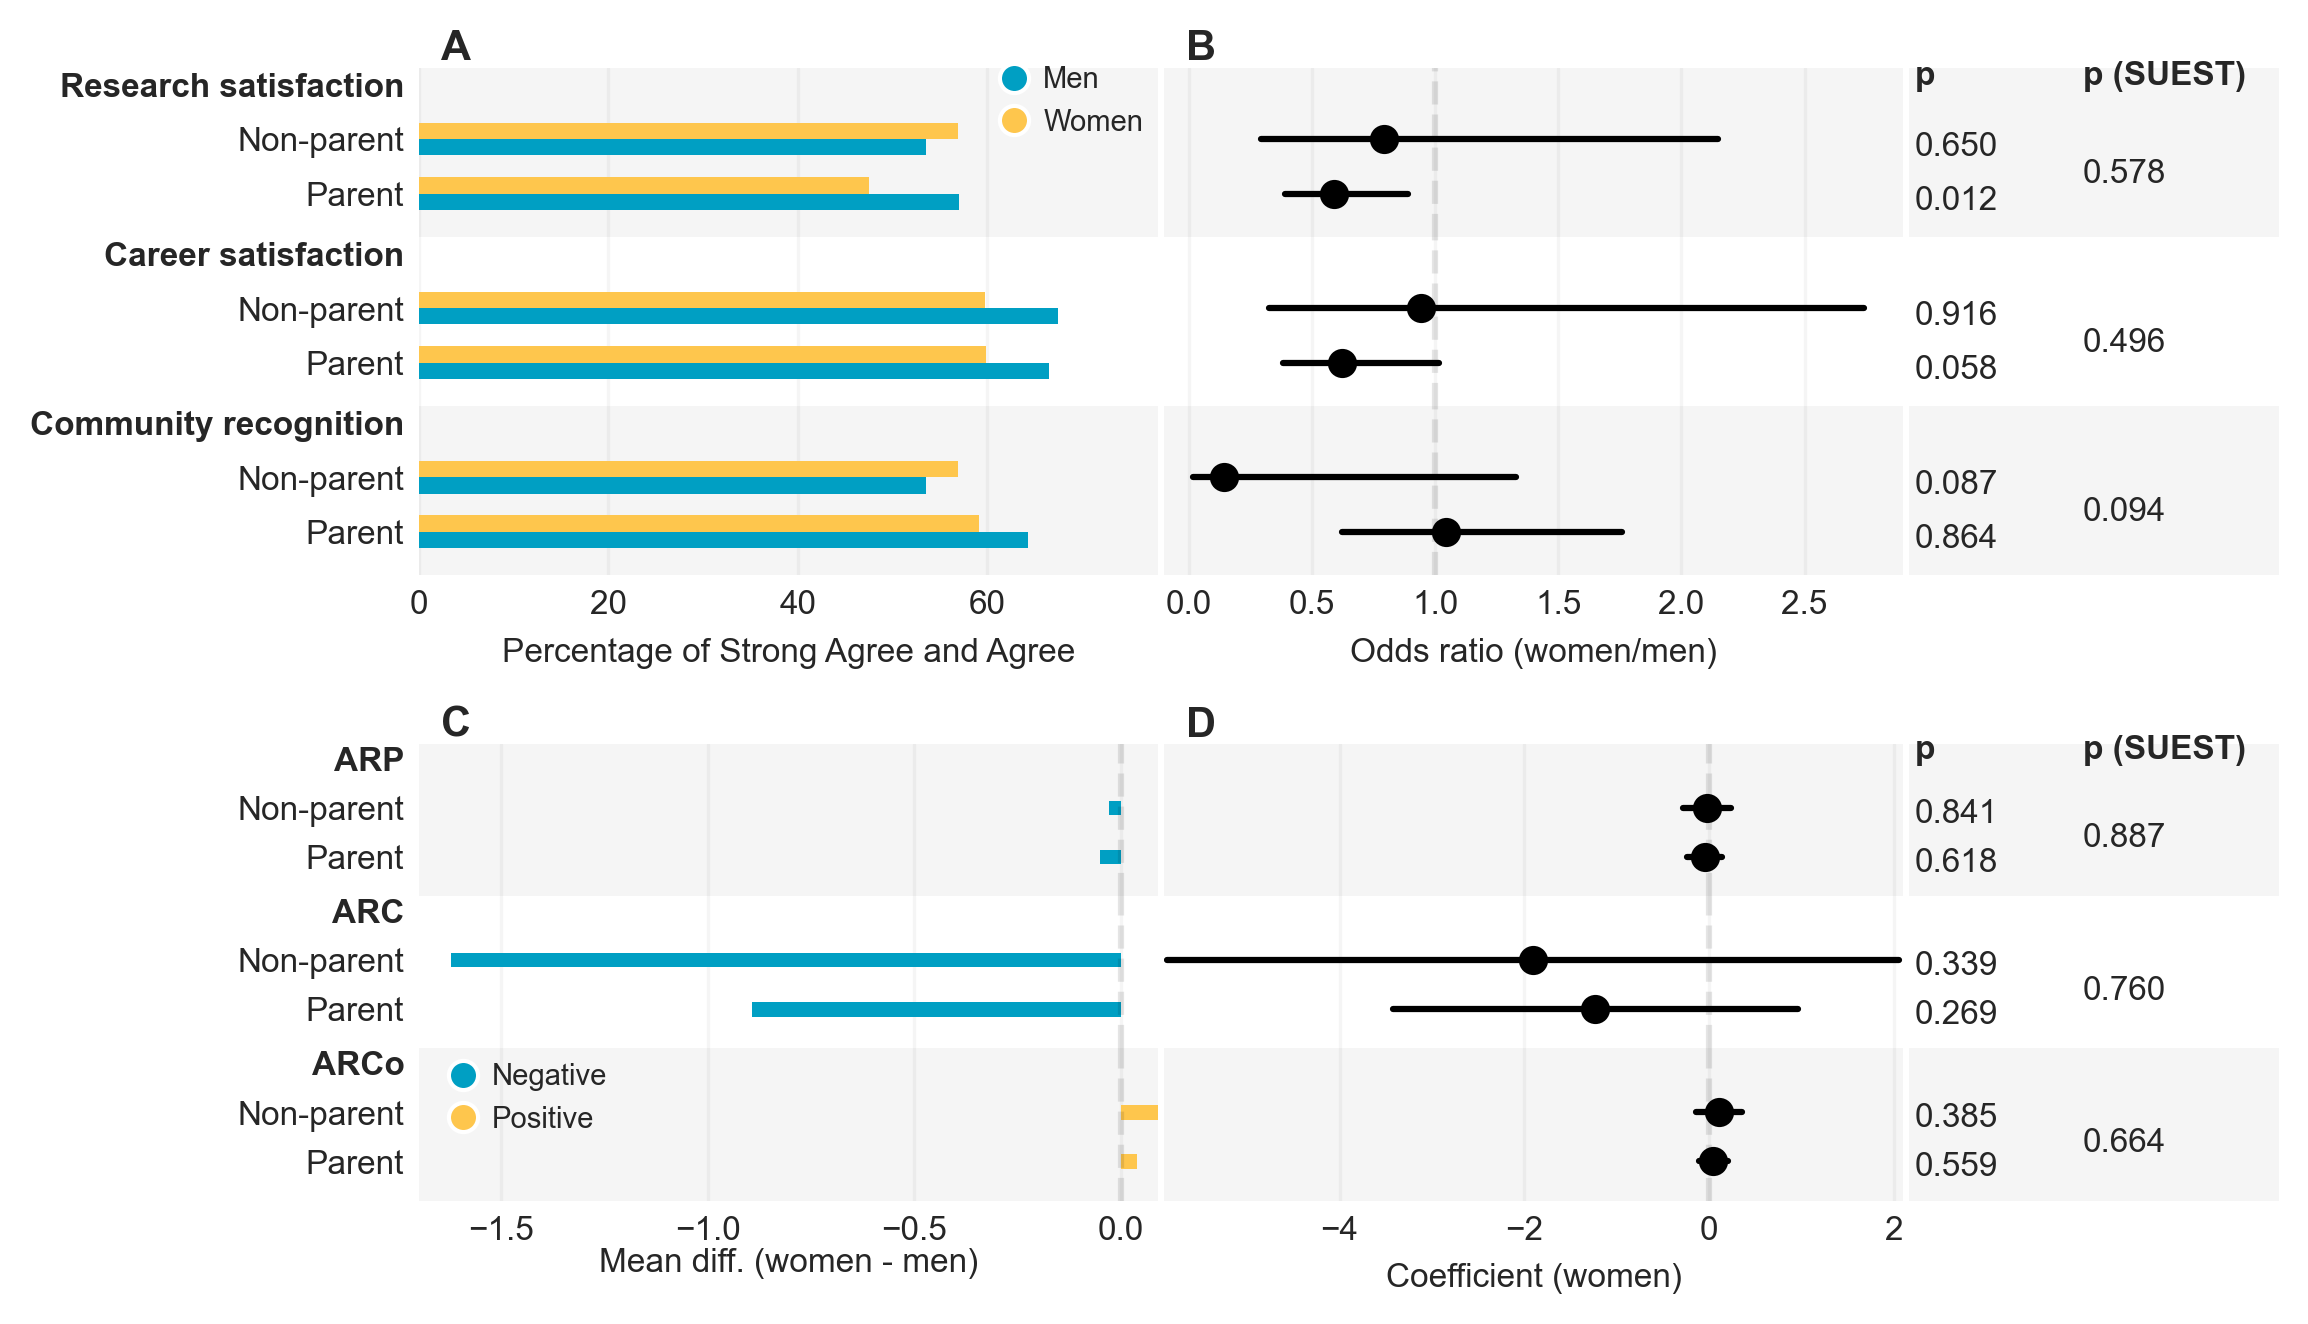

In [15]:
# Arts and humanities

def gen_multi_gs(figsize=(8,8), nrow=3,down_nrow=3, wspace=0.01, hspace=0.35, width_ratios=[1,1,0.5],height_ratios=[1,0.9]):
    fig = plt.figure(constrained_layout=True, figsize=figsize,dpi=300)
    gs0 = GridSpec(2, 3, wspace=wspace, hspace=hspace, width_ratios=width_ratios, height_ratios=height_ratios)
    gs00 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,0],wspace=0,hspace=0)
    gs01 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,1],wspace=0,hspace=0)
    gs02 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,2],wspace=0,hspace=0)
    gs10 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,0],wspace=0,hspace=0)
    gs11 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,1],wspace=0,hspace=0)
    gs12 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,2],wspace=0,hspace=0)
    
    axes_set = []
    for gs in [gs00, gs01, gs02]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(nrow)])
    for gs in [gs10, gs11, gs12]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(down_nrow)])
    return fig, axes_set

fig, axes_set= gen_multi_gs(figsize=(8,5))
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="subjective")
df_odd = df_odd[df_odd["area"] == 1] # change area
df0 = df[(df["area_Art"] == 1)] # change area
res=gen_res(df0)

questions = ["Research satisfaction",
"Career satisfaction",
"Community recognition"]
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          ypos=ypos,
          xlim=[0,78],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of Strong Agree and Agree")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[-0.1,2.9],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# bottom
df2 = df0[df0["gender_new"]!="Non-binary"]
plt.style.use("seaborn-white")
a_means = []
questions = ["ARP","ARC", "ARCo"]
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="biblio")
df_odd = df_odd[df_odd["area"] == 1] # change area

for val in ["rel_npap","rel_cite","uni_cola"]:
    pre = df2[df2["married_child"].isin([2,3]) & ~df2["rel_npap"].isnull()]
    pre0 = pd.pivot_table(pre,
                        values = val,
                        index = "gender_new",
                        columns = "married_child",
                        aggfunc=[np.mean, np.median])
    pre = pd.concat([pre0], keys=['All'], names=['rank'])
    a = pre.diff().drop("Men", level="gender_new").droplevel(level="gender_new")
    a_mean = a["mean"].stack().reset_index()
    a_means.append(a_mean)

plot_diff(axes_set[3],
          a_means,
          ypos=ypos,
          xlim=[-1.7,0.09],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors,
          xlabel="Mean diff. (women - men)")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[-5.9,2.1],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Coefficient (women)",
           vline=0)

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'AH.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)

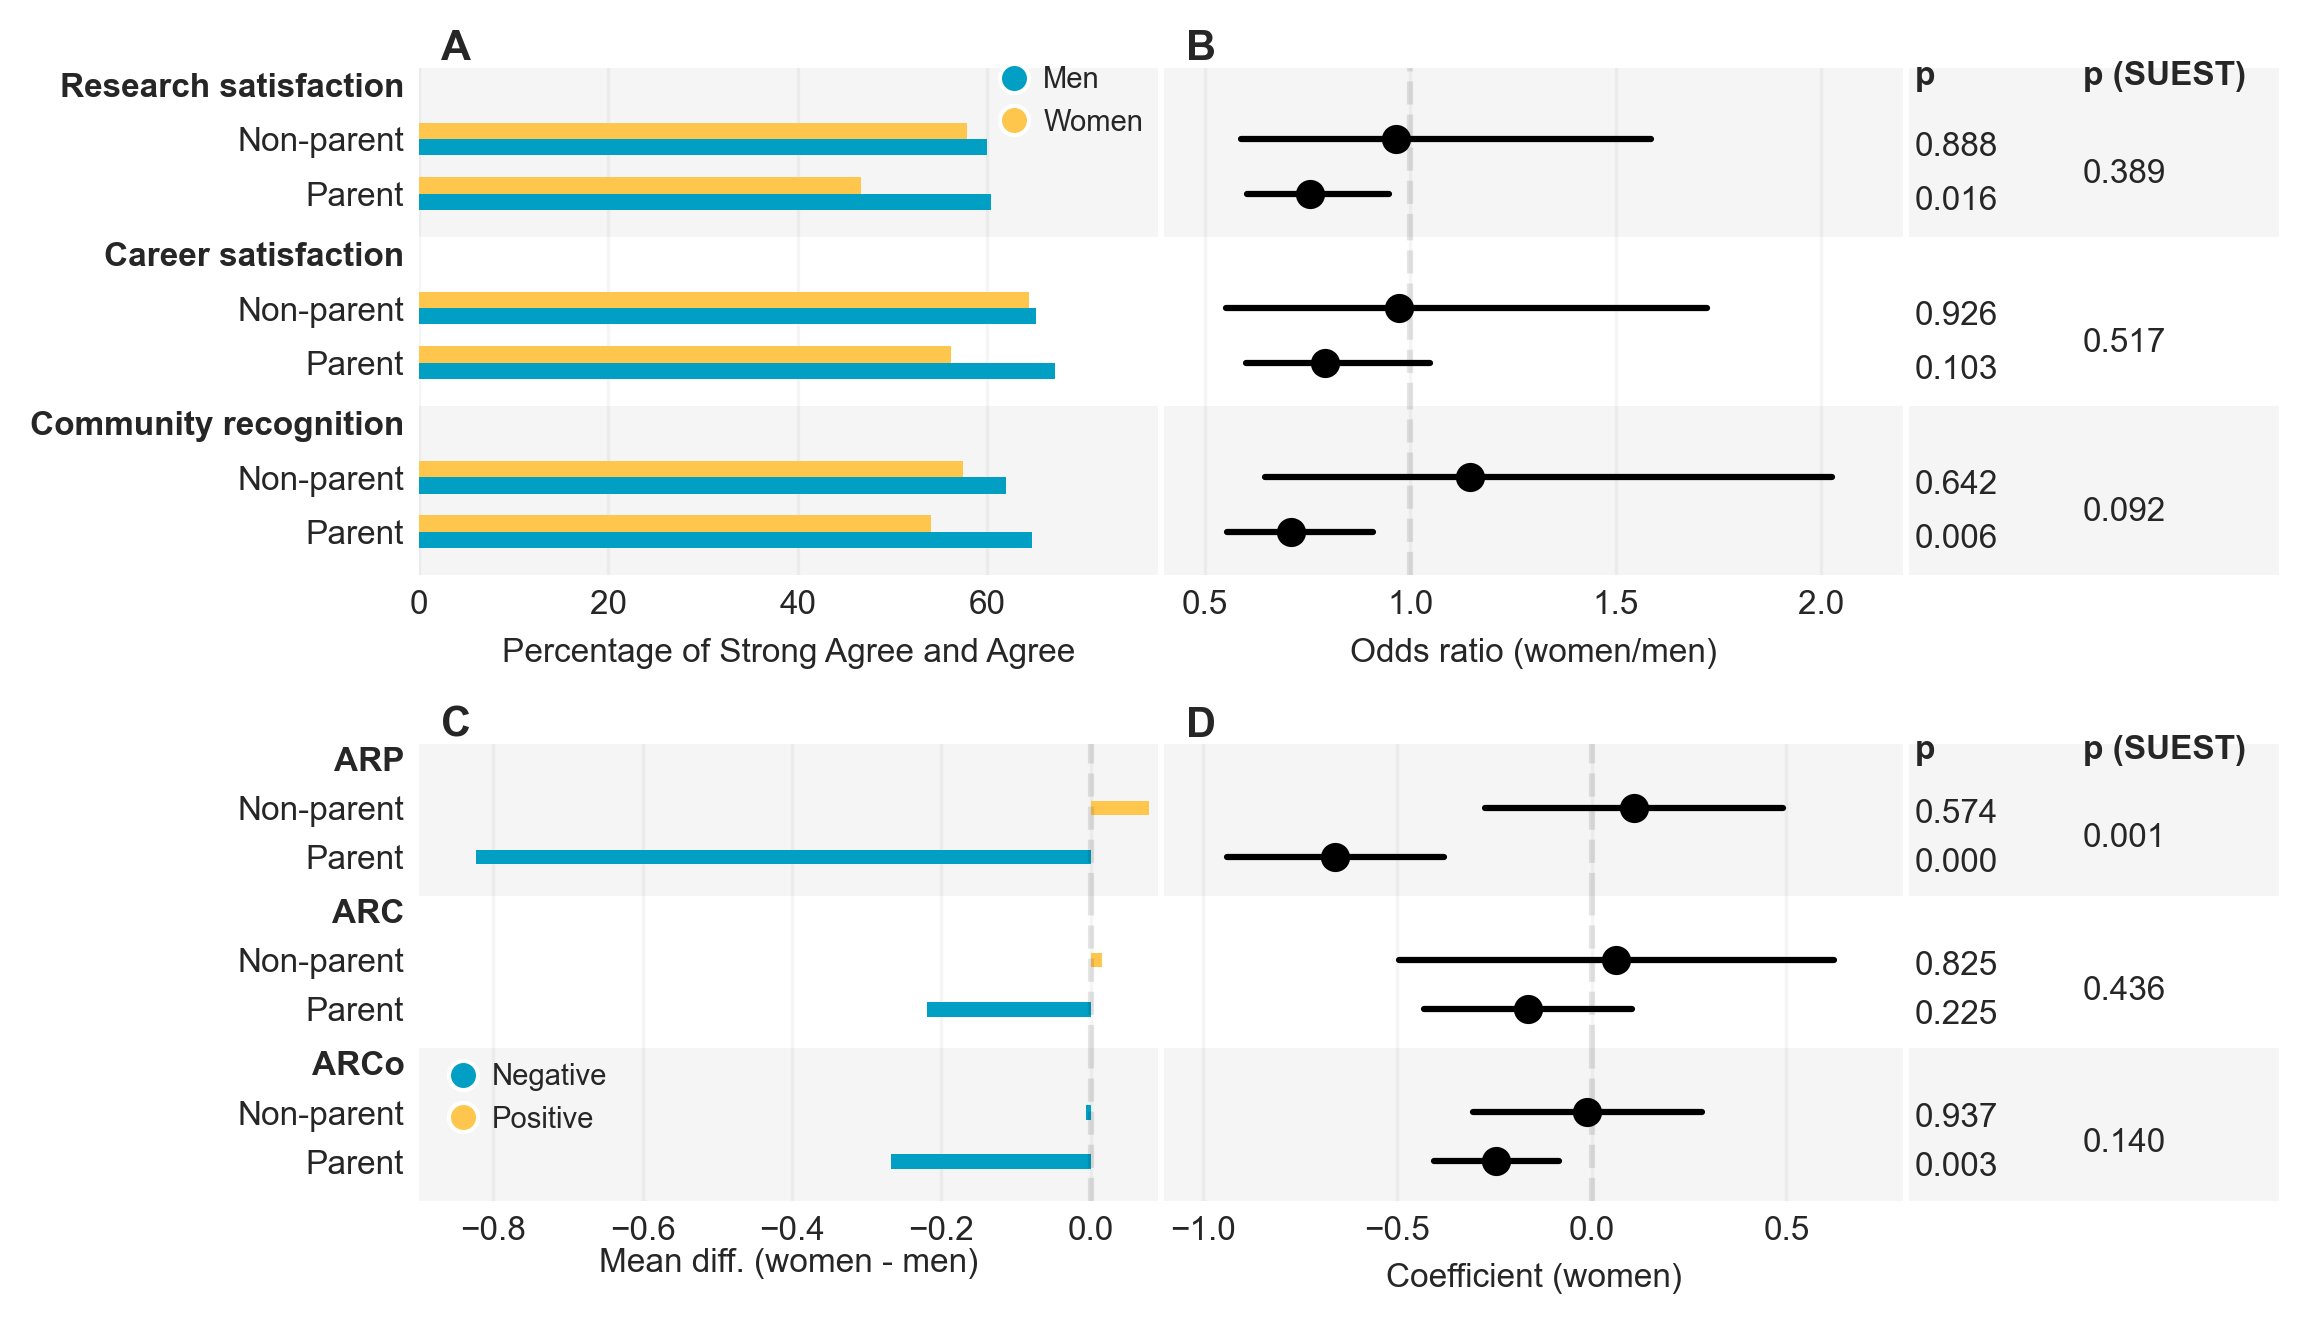

In [16]:
###### Medical

def gen_multi_gs(figsize=(8,8), nrow=3,down_nrow=3, wspace=0.01, hspace=0.35, width_ratios=[1,1,0.5],height_ratios=[1,0.9]):
    fig = plt.figure(constrained_layout=True, figsize=figsize,dpi=300)
    gs0 = GridSpec(2, 3, wspace=wspace, hspace=hspace, width_ratios=width_ratios, height_ratios=height_ratios)
    gs00 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,0],wspace=0,hspace=0)
    gs01 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,1],wspace=0,hspace=0)
    gs02 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,2],wspace=0,hspace=0)
    gs10 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,0],wspace=0,hspace=0)
    gs11 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,1],wspace=0,hspace=0)
    gs12 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,2],wspace=0,hspace=0)
    
    axes_set = []
    for gs in [gs00, gs01, gs02]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(nrow)])
    for gs in [gs10, gs11, gs12]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(down_nrow)])
    return fig, axes_set

fig, axes_set= gen_multi_gs(figsize=(8,5))
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="subjective")
df_odd = df_odd[df_odd["area"] == 2] # change area
df0 = df[(df["area_Med"] == 1)] # change area
res=gen_res(df0)

questions = ["Research satisfaction",
"Career satisfaction",
"Community recognition"]
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          ypos=ypos,
          xlim=[0,78],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of Strong Agree and Agree")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[0.4,2.2],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# bottom
df2 = df0[df0["gender_new"]!="Non-binary"]
plt.style.use("seaborn-white")
a_means = []
questions = ["ARP","ARC", "ARCo"]
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="biblio")
df_odd = df_odd[df_odd["area"] == 2] # change area

for val in ["rel_npap","rel_cite","uni_cola"]:
    pre = df2[df2["married_child"].isin([2,3]) & ~df2["rel_npap"].isnull()]
    pre0 = pd.pivot_table(pre,
                        values = val,
                        index = "gender_new",
                        columns = "married_child",
                        aggfunc=[np.mean, np.median])
    pre = pd.concat([pre0], keys=['All'], names=['rank'])
    a = pre.diff().drop("Men", level="gender_new").droplevel(level="gender_new")
    a_mean = a["mean"].stack().reset_index()
    a_means.append(a_mean)

plot_diff(axes_set[3],
          a_means,
          ypos=ypos,
          xlim=[-0.9,0.09],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors,
          xlabel="Mean diff. (women - men)")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[-1.1,0.8],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Coefficient (women)",
           vline=0)

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'med.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)

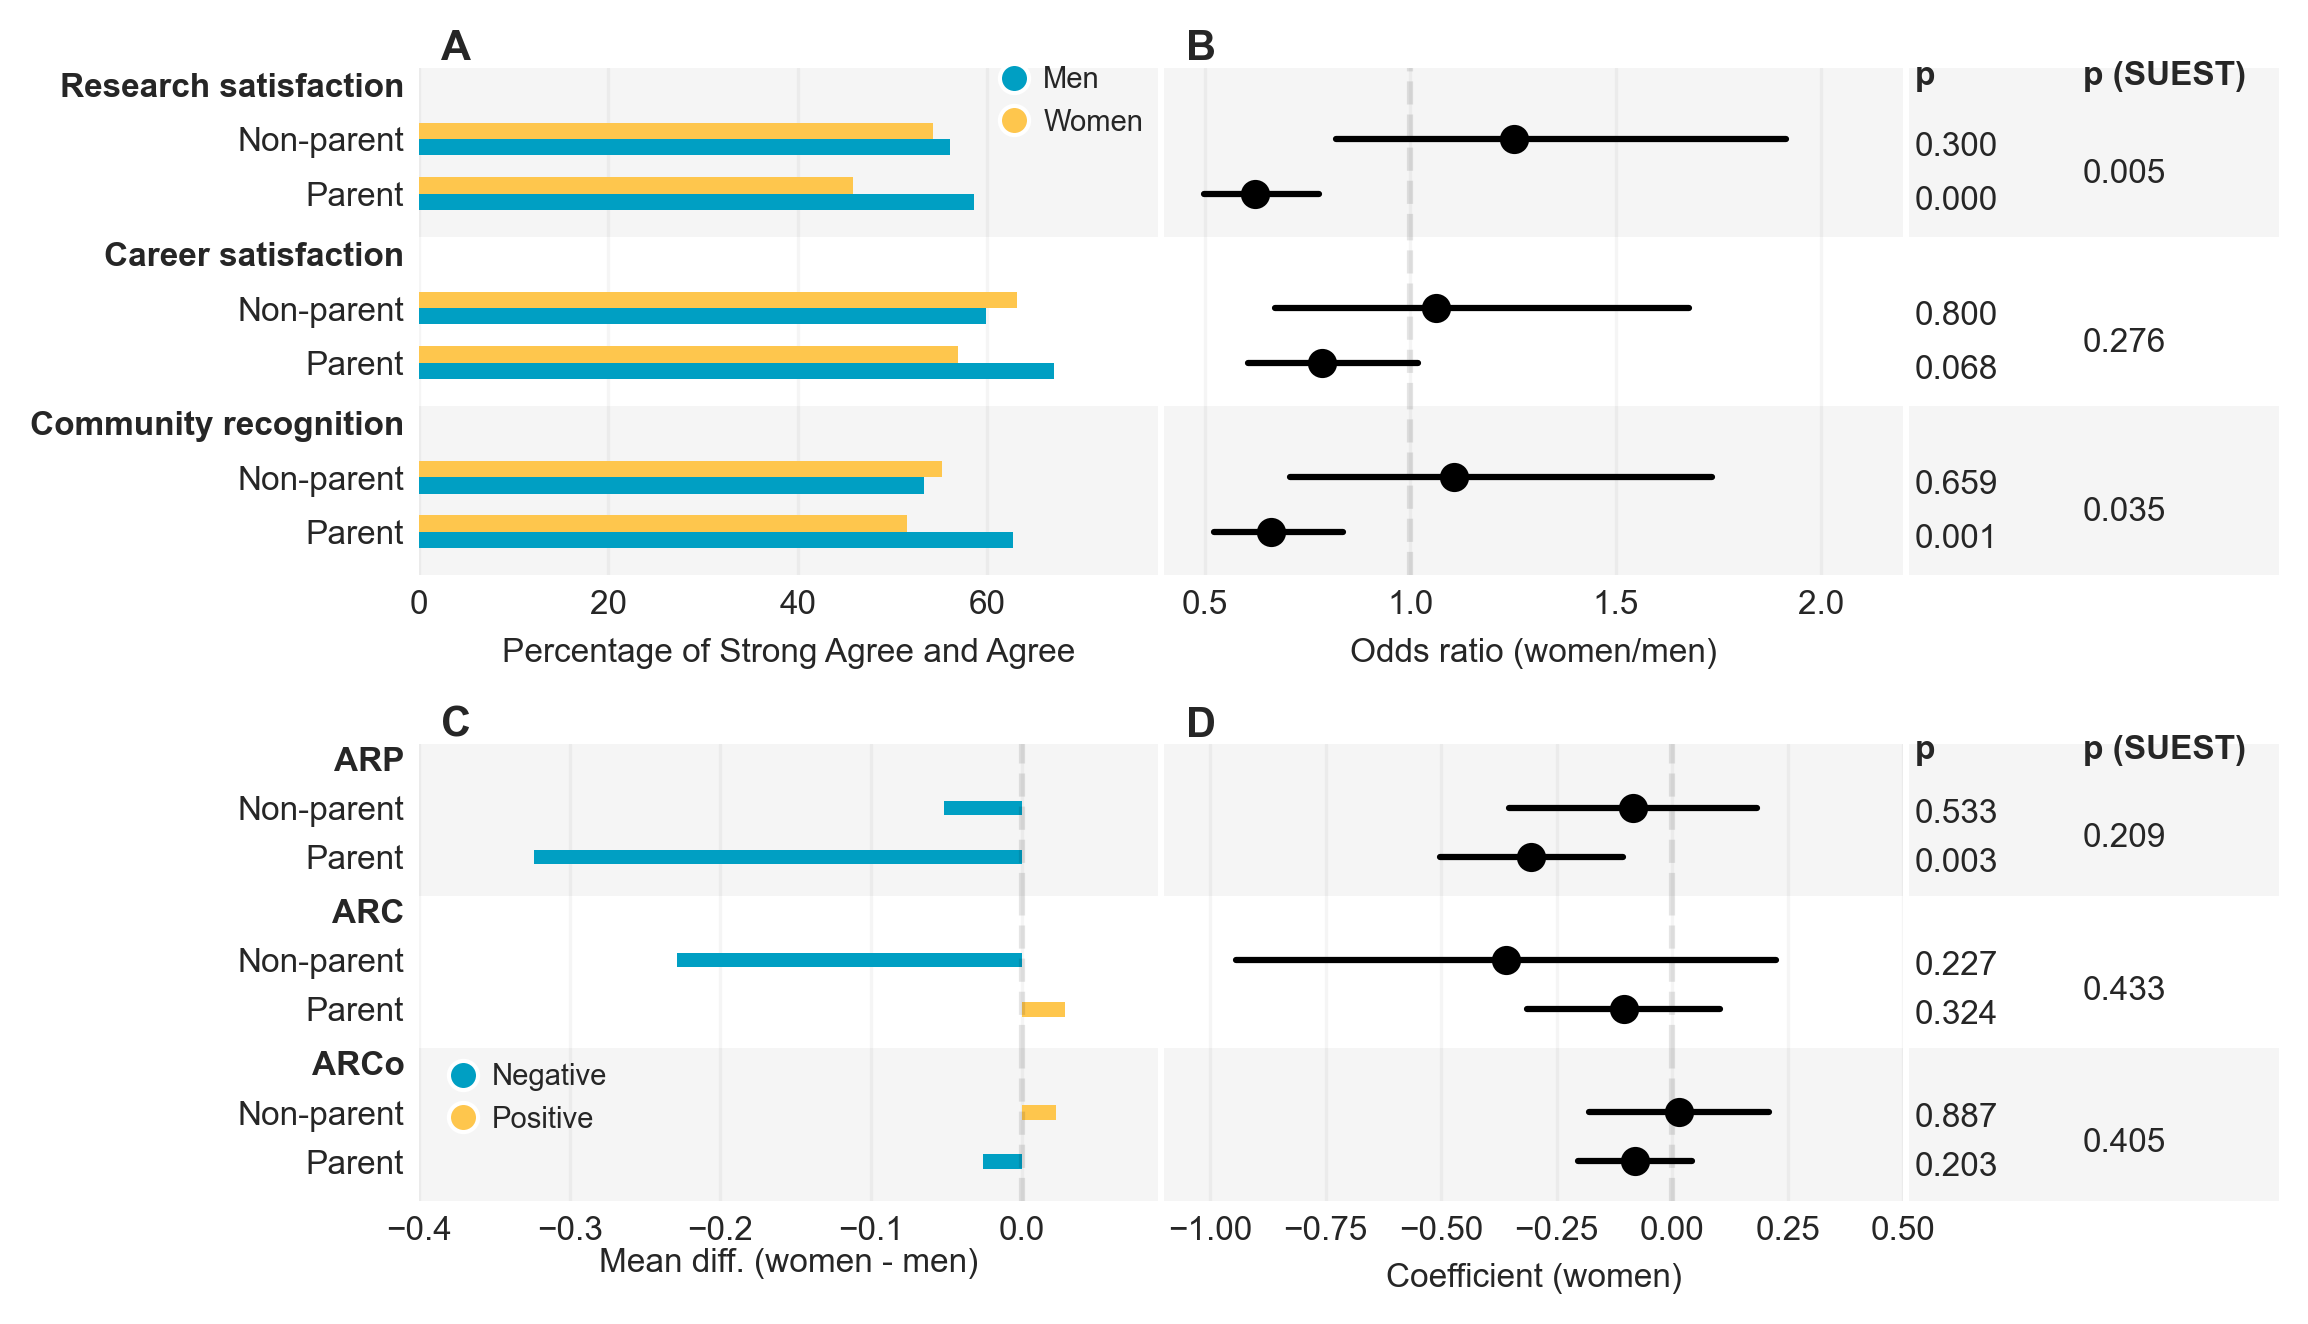

In [10]:
# NSE

def gen_multi_gs(figsize=(8,8), nrow=3,down_nrow=3, wspace=0.01, hspace=0.35, width_ratios=[1,1,0.5],height_ratios=[1,0.9]):
    fig = plt.figure(constrained_layout=True, figsize=figsize,dpi=300)
    gs0 = GridSpec(2, 3, wspace=wspace, hspace=hspace, width_ratios=width_ratios, height_ratios=height_ratios)
    gs00 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,0],wspace=0,hspace=0)
    gs01 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,1],wspace=0,hspace=0)
    gs02 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,2],wspace=0,hspace=0)
    gs10 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,0],wspace=0,hspace=0)
    gs11 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,1],wspace=0,hspace=0)
    gs12 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,2],wspace=0,hspace=0)
    
    axes_set = []
    for gs in [gs00, gs01, gs02]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(nrow)])
    for gs in [gs10, gs11, gs12]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(down_nrow)])
    return fig, axes_set

fig, axes_set= gen_multi_gs(figsize=(8,5))
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="subjective")
df_odd = df_odd[df_odd["area"] == 3] # change area
df0 = df[(df["area_Nat"] == 1)] # change area
res=gen_res(df0)

questions = ["Research satisfaction",
"Career satisfaction",
"Community recognition"]
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          ypos=ypos,
          xlim=[0,78],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of Strong Agree and Agree")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[0.4,2.2],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# bottom
df2 = df0[df0["gender_new"]!="Non-binary"]
plt.style.use("seaborn-white")
a_means = []
questions = ["ARP","ARC", "ARCo"]
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="biblio")
df_odd = df_odd[df_odd["area"] == 3] # change area

for val in ["rel_npap","rel_cite","uni_cola"]:
    pre = df2[df2["married_child"].isin([2,3]) & ~df2["rel_npap"].isnull()]
    pre0 = pd.pivot_table(pre,
                        values = val,
                        index = "gender_new",
                        columns = "married_child",
                        aggfunc=[np.mean, np.median])
    pre = pd.concat([pre0], keys=['All'], names=['rank'])
    a = pre.diff().drop("Men", level="gender_new").droplevel(level="gender_new")
    a_mean = a["mean"].stack().reset_index()
    a_means.append(a_mean)

plot_diff(axes_set[3],
          a_means,
          ypos=ypos,
          xlim=[-0.4,0.09],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors,
          xlabel="Mean diff. (women - men)")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[-1.1,0.5],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Coefficient (women)",
           vline=0)

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'nse.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)

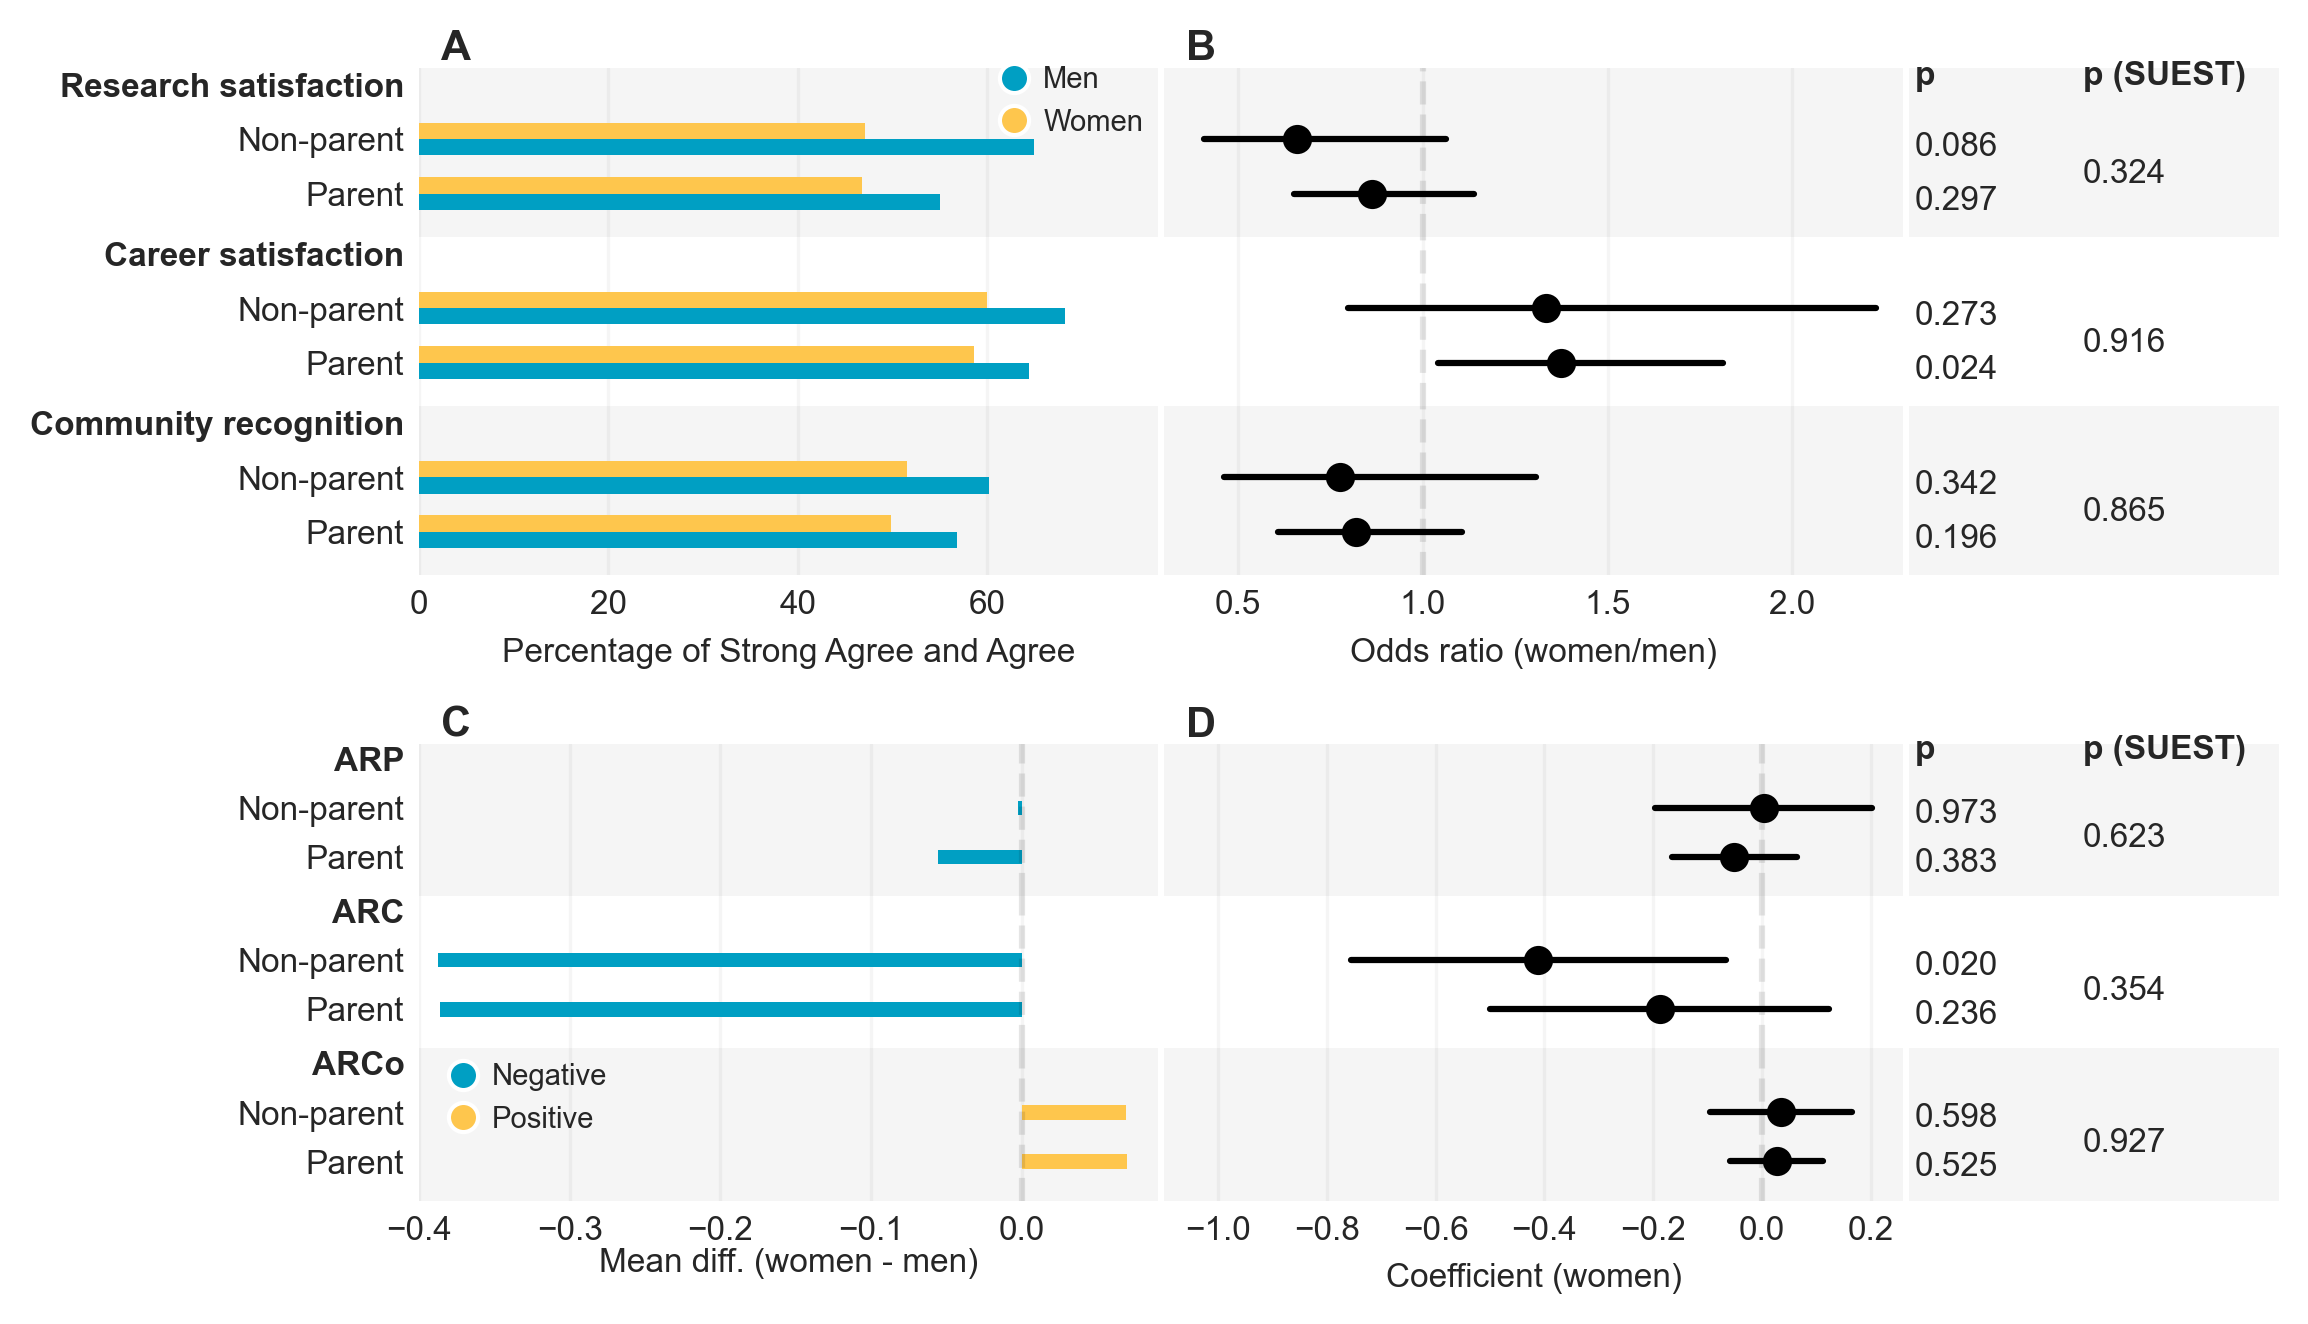

In [11]:
# Social science

def gen_multi_gs(figsize=(8,8), nrow=3,down_nrow=3, wspace=0.01, hspace=0.35, width_ratios=[1,1,0.5],height_ratios=[1,0.9]):
    fig = plt.figure(constrained_layout=True, figsize=figsize,dpi=300)
    gs0 = GridSpec(2, 3, wspace=wspace, hspace=hspace, width_ratios=width_ratios, height_ratios=height_ratios)
    gs00 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,0],wspace=0,hspace=0)
    gs01 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,1],wspace=0,hspace=0)
    gs02 = GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs0[0,2],wspace=0,hspace=0)
    gs10 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,0],wspace=0,hspace=0)
    gs11 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,1],wspace=0,hspace=0)
    gs12 = GridSpecFromSubplotSpec(down_nrow, 1, subplot_spec=gs0[1,2],wspace=0,hspace=0)
    
    axes_set = []
    for gs in [gs00, gs01, gs02]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(nrow)])
    for gs in [gs10, gs11, gs12]:
        axes_set.append([plt.subplot(gs[i,0]) for i in range(down_nrow)])
    return fig, axes_set

fig, axes_set= gen_multi_gs(figsize=(8,5))
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="subjective")
df_odd = df_odd[df_odd["area"] == 4] # change area
df0 = df[(df["area_Soc"] == 1)] # change area
res=gen_res(df0)

questions = ["Research satisfaction",
"Career satisfaction",
"Community recognition"]
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          ypos=ypos,
          xlim=[0,78],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of Strong Agree and Agree")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[0.3,2.3],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# bottom
df2 = df0[df0["gender_new"]!="Non-binary"]
plt.style.use("seaborn-white")
a_means = []
questions = ["ARP","ARC", "ARCo"]
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="biblio")
df_odd = df_odd[df_odd["area"] == 4] # change area

for val in ["rel_npap","rel_cite","uni_cola"]:
    pre = df2[df2["married_child"].isin([2,3]) & ~df2["rel_npap"].isnull()]
    pre0 = pd.pivot_table(pre,
                        values = val,
                        index = "gender_new",
                        columns = "married_child",
                        aggfunc=[np.mean, np.median])
    pre = pd.concat([pre0], keys=['All'], names=['rank'])
    a = pre.diff().drop("Men", level="gender_new").droplevel(level="gender_new")
    a_mean = a["mean"].stack().reset_index()
    a_means.append(a_mean)

plot_diff(axes_set[3],
          a_means,
          ypos=ypos,
          xlim=[-0.4,0.09],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors,
          xlabel="Mean diff. (women - men)")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[-1.1,0.26],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Coefficient (women)",
           vline=0)

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'ss.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)

# Conflict & support

In [12]:
satis = ["tim_conf", "str_conf","beh_conf"]

res = pd.DataFrame()
for i in range(len(satis)):
    a = pd.crosstab([df["married_child"],df["gender_new"]],df[satis[i]]).drop(["Non-binary"], level="gender_new")
    total = a.sum(level=[0], axis=0)
    total.index = pd.MultiIndex.from_product([total.index, ["Total"]])
    a = pd.concat([a,total],axis=0).sort_index(level=0)
    a = a.div(a.apply(sum, axis=1),axis=0)*100
    a.columns = pd.MultiIndex.from_product([[i], a.columns])
    res = pd.concat([res,a],axis=1)

res2 = pd.DataFrame()
df1 = df[df["married_child"].isin([2,3])]
for i in range(len(satis)):
    a = pd.crosstab(df1["gender_new"],df1[satis[i]]).drop(["Non-binary"])
    total = a.sum(axis=0)
    total.name = "Total"
    a = a.append(total)
    a = a.div(a.apply(sum, axis=1),axis=0)*100
    a.columns = pd.MultiIndex.from_product([[i], a.columns])
    res2 = pd.concat([res2,a],axis=1)

res2.index = pd.MultiIndex.from_product([["All"], res2.index])
res = pd.concat([res,res2])
res

0                                   \
tim_conf                         0.0        1.0        2.0        3.0   
married_child gender_new                                                
0             Men         100.000000   0.000000   0.000000   0.000000   
              Total        55.555556   0.000000  11.111111  33.333333   
              Women        20.000000   0.000000  20.000000  60.000000   
1             Total        20.000000  20.000000  20.000000  40.000000   
              Women        20.000000  20.000000  20.000000  40.000000   
2             Men          13.957597  24.911661  33.745583  27.385159   
              Total        11.111111  23.293173  31.057564  34.538153   
              Women         9.375000  22.306034  29.418103  38.900862   
3             Men           6.013540  20.430108  34.846675  38.709677   
              Total         3.841366  16.894896  31.709052  47.554686   
              Women         2.088689  14.042416  29.177378  54.691517   
All           Men           7.474813  21.254469  34.644134  36.626584   
              Women         3.762376  15.940594  29.232673  51.064356   
              Total         5.367430  18.238022  31.572292  44.822257   

                                   1                                   \
tim_conf                         0.0        1.0        2.0        3.0   
married_child gender_new                                                
0             Men         100.000000   0.000000   0.000000   0.000000   
              Total        77.777778   0.000000  11.111111  11.111111   
              Women        60.000000   0.000000  20.000000  20.000000   
1             Total        20.000000   0.000000  40.000000  40.000000   
              Women        20.000000   0.000000  40.000000  40.000000   
2             Men          31.382979  34.574468  20.035461  14.007092   
              Total        29.704301  32.795699  22.311828  15.188172   
              Women        28.679654  31.709957  23.701299  15.909091   
3             Men          18.283433  32.854291  28.383234  20.479042   
              Total        14.031022  30.201462  29.577465  26.190052   
              Women        10.599227  28.060567  30.541237  30.798969   
All           Men          20.690779  33.170414  26.849137  19.289671   
              Women        14.746773  28.897716  28.972195  27.383317   
              Total        17.317176  30.745385  28.054107  23.883331   

                                   2                                   
tim_conf                         0.0        1.0        2.0        3.0  
married_child gender_new                                               
0             Men         100.000000   0.000000   0.000000   0.000000  
              Total        77.777778  22.222222   0.000000   0.000000  
              Women        60.000000  40.000000   0.000000   0.000000  
1             Total        40.000000  20.000000  40.000000   0.000000  
              Women        40.000000  20.000000  40.000000   0.000000  
2             Men          71.301248  13.903743   9.625668   5.169340  
              Total        66.644114  15.493911  10.419486   7.442490  
              Women        63.794984  16.466739  10.905125   8.833152  
3             Men          61.770624  18.712274  11.670020   7.847082  
              Total        59.184773  18.225893  12.677321   9.912013  
              Women        57.101167  17.833982  13.488975  11.575875  
All           Men          63.525936  17.826658  11.293500   7.353907  
              Women        58.635341  17.520620  12.896776  10.947263  
              Total        60.749255  17.652902  12.203775   9.394068

In [13]:
satis = ["fin_sup", "emo_sup", "time_sup", "dec_sup", "tec_sup", "net_sup"]

res_sup = pd.DataFrame()
for i in range(len(satis)):
    a = pd.crosstab([df["married_child"],df["gender_new"]],df[satis[i]]).drop(["Non-binary"], level="gender_new")
    total = a.sum(level=[0], axis=0)
    total.index = pd.MultiIndex.from_product([total.index, ["Total"]])
    a = pd.concat([a,total],axis=0).sort_index(level=0)
    a = a.div(a.apply(sum, axis=1),axis=0)*100
    a.columns = pd.MultiIndex.from_product([[i], a.columns])
    res_sup = pd.concat([res_sup,a],axis=1)

res_sup2 = pd.DataFrame()
df1 = df[df["married_child"].isin([2,3])]
for i in range(len(satis)):
    a = pd.crosstab(df1["gender_new"],df1[satis[i]]).drop(["Non-binary"])
    total = a.sum(axis=0)
    total.name = "Total"
    a = a.append(total)
    a = a.div(a.apply(sum, axis=1),axis=0)*100
    a.columns = pd.MultiIndex.from_product([[i], a.columns])
    res_sup2 = pd.concat([res_sup2,a],axis=1)

res_sup2.index = pd.MultiIndex.from_product([["All"], res_sup2.index])
res_sup = pd.concat([res_sup,res_sup2])
res_sup

0                                   \
fin_sup                         0.0        1.0        2.0        3.0   
married_child gender_new                                               
0             Men         66.666667  33.333333   0.000000   0.000000   
              Total       60.000000  40.000000   0.000000   0.000000   
              Women       50.000000  50.000000   0.000000   0.000000   
1             Total       75.000000  25.000000   0.000000   0.000000   
              Women       75.000000  25.000000   0.000000   0.000000   
2             Men         30.144404  30.685921  20.758123  18.411552   
              Total       30.369357  26.607387  22.024624  20.998632   
              Women       30.506608  24.118943  22.797357  22.577093   
3             Men         24.380333  27.184072  24.583503  23.852093   
              Total       20.087575  23.280423  24.119686  32.512315   
              Women       16.589404  20.099338  23.741722  39.569536   
All           Men         25.439469  27.827529  23.880597  22.852405   
              Women       19.806517  21.028513  23.523422  35.641548   
              Total       22.252629  23.980988  23.678525  30.087858   

                                  1                                    \
fin_sup                         0.0        1.0         2.0        3.0   
married_child gender_new                                                
0             Men          0.000000   0.000000  100.000000   0.000000   
              Total       12.500000   0.000000   50.000000  37.500000   
              Women       20.000000   0.000000   20.000000  60.000000   
1             Total       50.000000  25.000000   25.000000   0.000000   
              Women       50.000000  25.000000   25.000000   0.000000   
2             Men          1.953819   7.992895   19.715808  70.337478   
              Total        1.604278   8.021390   18.114973  72.259358   
              Women        1.393355   8.038585   17.148982  73.419078   
3             Men          2.363782  11.698718   22.596154  63.341346   
              Total        2.824455  12.102252   23.131927  61.941366   
              Women        3.195610  12.427372   23.563589  60.813428   
All           Men          2.288330  11.016672   22.066035  64.628964   
              Women        2.778467  11.411560   22.078889  63.731084   
              Total        2.566996  11.241185   22.073343  64.118477   

                                  2             ...          3             \
fin_sup                         0.0        1.0  ...        2.0        3.0   
married_child gender_new                        ...                         
0             Men         66.666667   0.000000  ...  33.333333  33.333333   
              Total       25.000000  25.000000  ...  50.000000  16.666667   
              Women        0.000000  40.000000  ...  66.666667   0.000000   
1             Total       50.000000   0.000000  ...  50.000000  25.000000   
              Women       50.000000   0.000000  ...  50.000000  25.000000   
2             Men          8.037383  22.803738  ...  25.800377  48.775895   
              Total        7.188161  21.775899  ...  24.167873  52.821997   
              Women        6.674208  21.153846  ...  23.149236  55.346651   
3             Men          2.625103   8.367514  ...  27.723195  49.850491   
              Total        3.398764  13.994911  ...  25.939630  49.230769   
              Women        4.014360  18.472585  ...  24.445240  48.711525   
All           Men          3.599058  10.965355  ...  27.367688  49.651811   
              Women        4.609929  19.072948  ...  24.142661  50.260631   
              Total        4.175697  15.590233  ...  25.563910  49.992328   

                                  4                                   \
fin_sup                         0.0        1.0        2.0        3.0   
married_child gender_new                                               
0             Men         66.666667  33.3

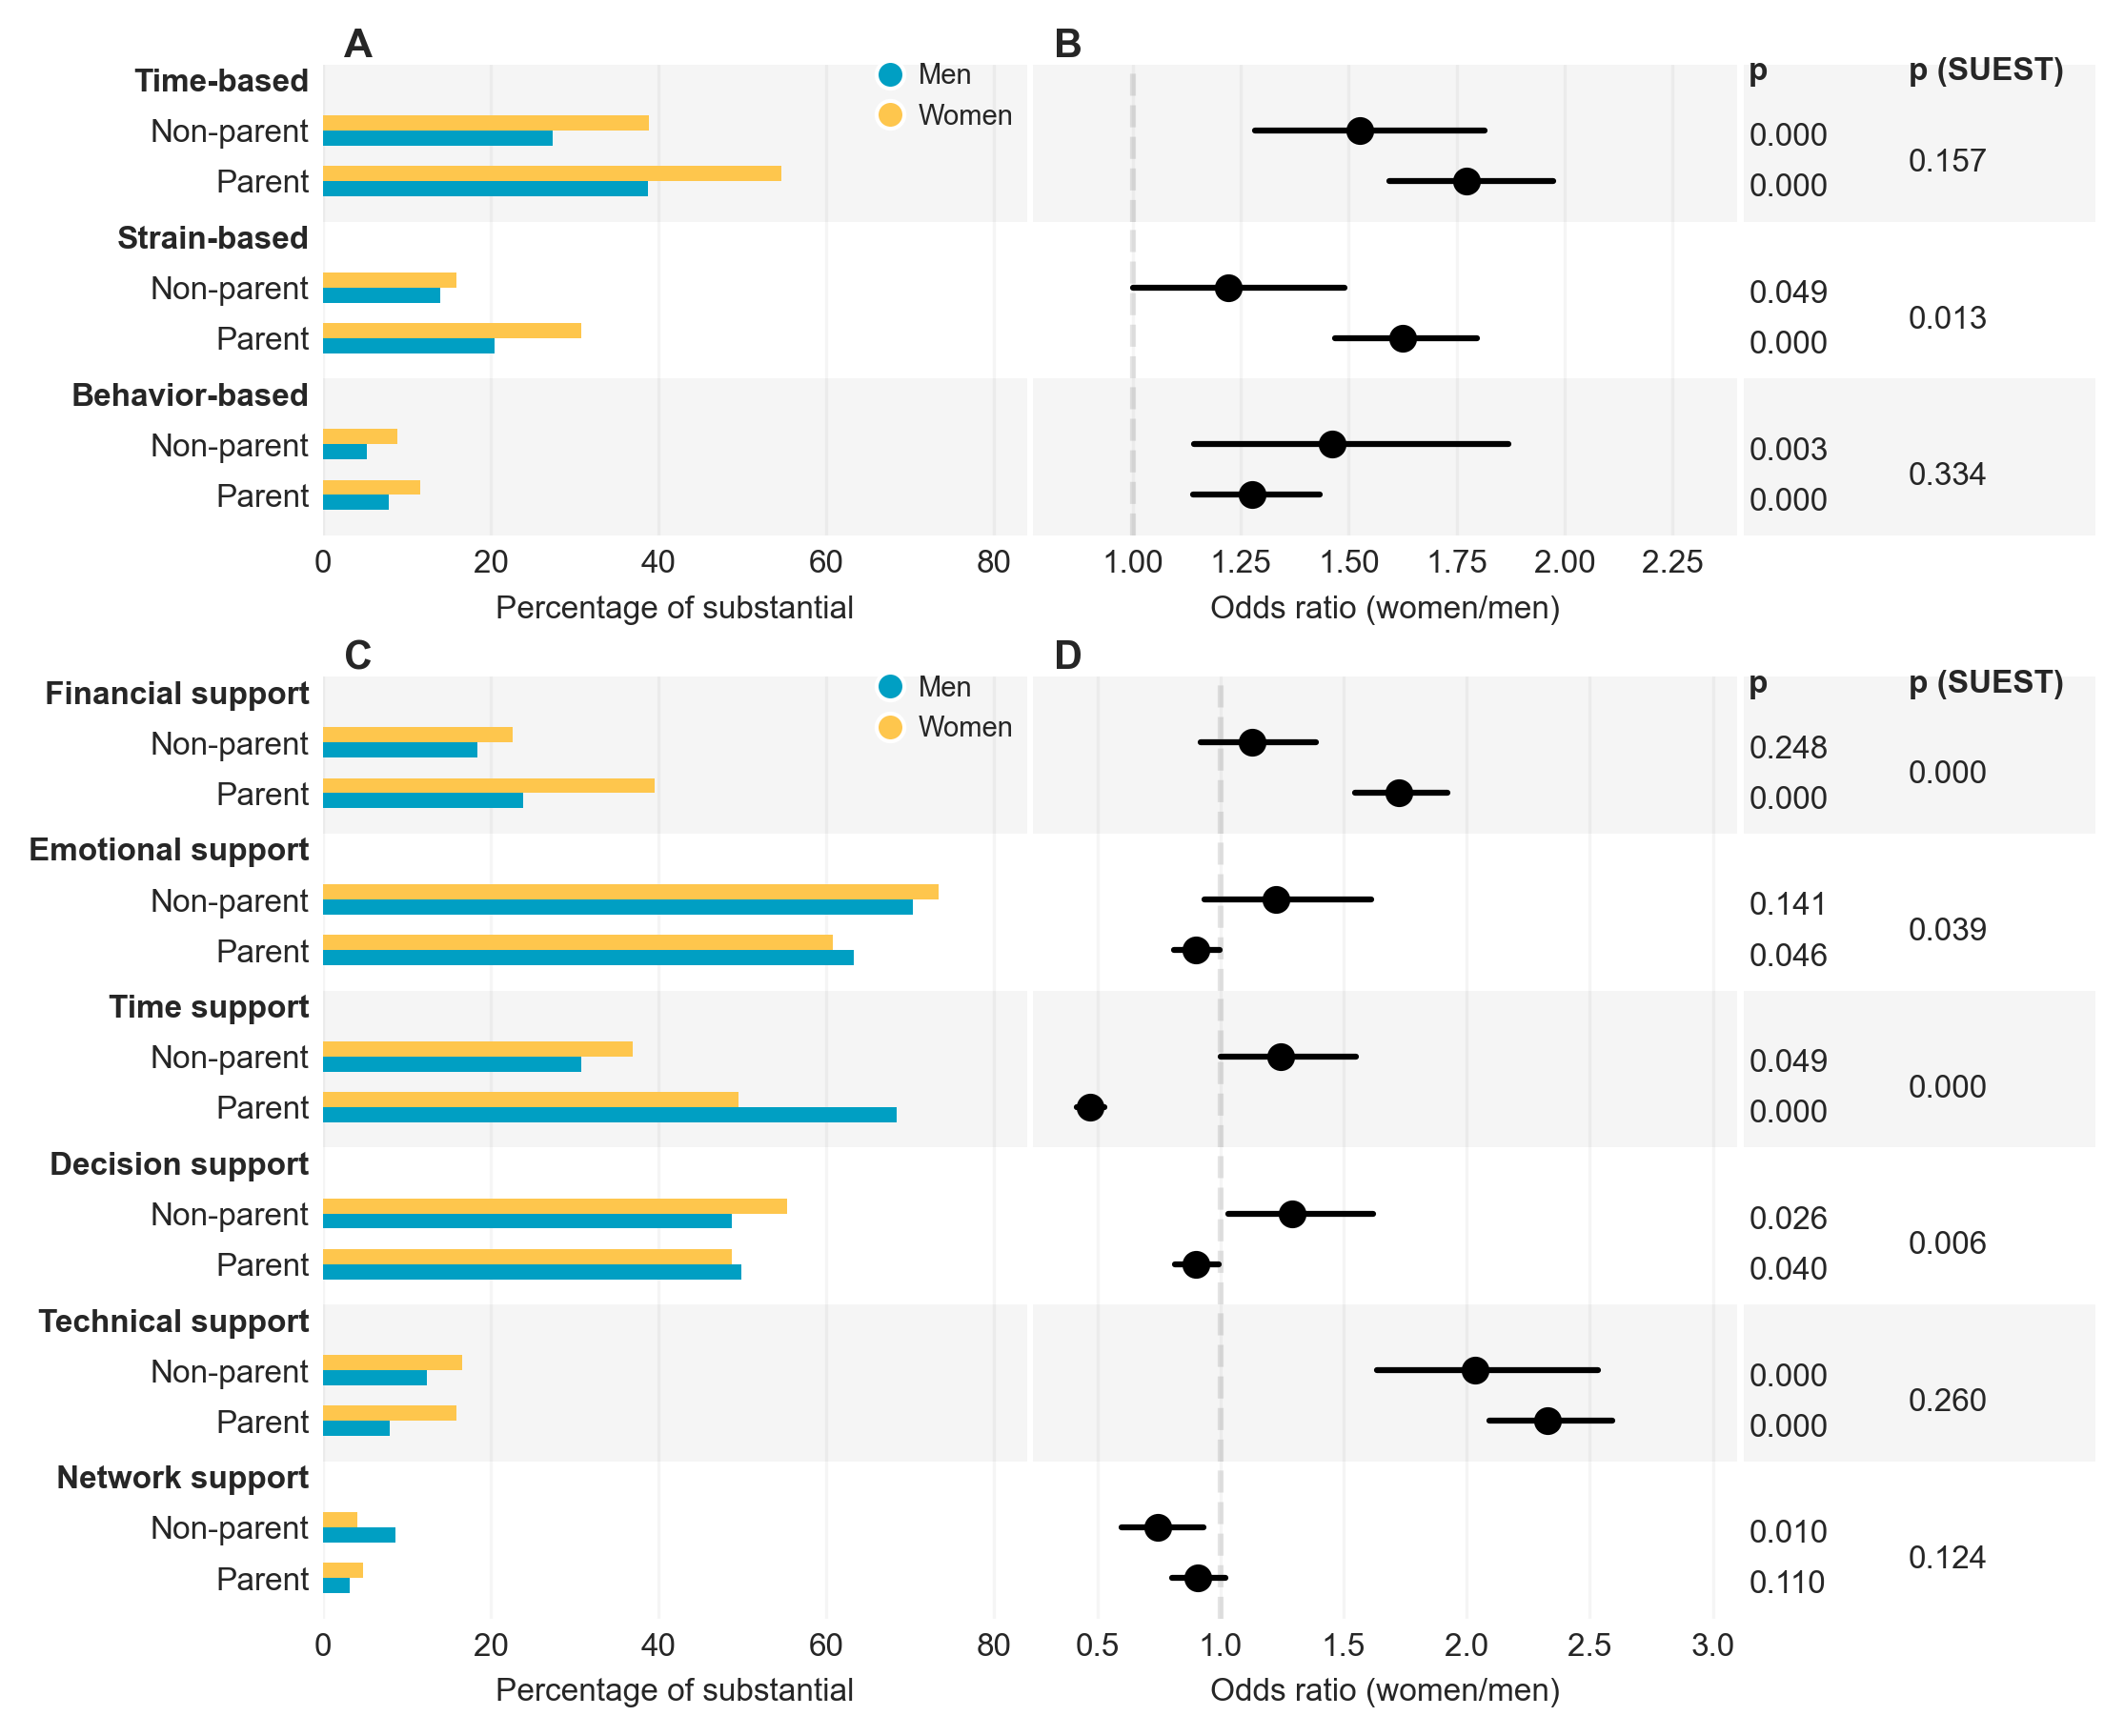

In [14]:
# odds ratio graph
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="work_conflict")
questions = ["Time-based",
"Strain-based",
"Behavior-based",]
plt.style.use('seaborn-white')

fig, axes_set= gen_multi_gs(figsize=(8,7.2),nrow=3,down_nrow=6,hspace=0.2,height_ratios=[1,2])
xpos=[-0.3,0.3]
ypos=[0,1,2]
xlim=[-0.32,1]
ylim=[-0.8,2.3]
w=0.3
groups = ["Parent", "Non-parent"]
colors = ["#009FC3","#FEC64D"]# male, female

plot_hbar(axes_set[0],
          res,
          target_ans=3,
          ypos=ypos,
          xlim=[0,84],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of substantial")

plot_forest(axes_set[1],
            df_odd,
            ypos=ypos,
            xlim=[0.77,2.4],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[2],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

# odds ratio graph
df_odd = pd.read_excel(os.path.join(root, or_file_name), sheet_name="support")
questions = ["Financial support",
          "Emotional support",
          "Time support",
          "Decision support",
          "Technical support",
          "Network support"]
plt.style.use('seaborn-white')

plot_hbar(axes_set[3],
          res_sup,
          target_ans=3,
          ypos=ypos,
          xlim=[0,84],
          ylim=ylim,
          w=w,
          groups = groups,
          colors = colors, 
          xlabel="Percentage of substantial")

plot_forest(axes_set[4],
            df_odd,
            ypos=ypos,
            xlim=[0.24,3.1],
            ylim=ylim,
            groups = groups,
            palette = ["black","black"],
            xlabel="Odds ratio (women/men)")

sueststar(axes_set[5],
          xpos=xpos,
          ypos=ypos,
          offset=-0.3,
          xlim=xlim,
          ylim=ylim)

panel_loc = [0.03,1.05]
axes_set[0][0].text(*panel_loc,"A",fontweight="bold",transform=axes_set[0][0].transAxes)
axes_set[1][0].text(*panel_loc,"B",fontweight="bold",transform=axes_set[1][0].transAxes)
axes_set[3][0].text(*panel_loc,"C",fontweight="bold",transform=axes_set[3][0].transAxes)
axes_set[4][0].text(*panel_loc,"D",fontweight="bold",transform=axes_set[4][0].transAxes)

plt.tight_layout()
sns.despine(left=True, bottom=True, right=True)
plt.show()
fig.savefig(r'fig2.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)